In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
def get_costs_from_df(df):
    return df["config_point_result"].loc[:, ['execution_time', 'cost_to_run']]
    
# Pareto front is defined as the set of points where one cost cannot be greater without lowering the other one
# Ideally this function will return the indexes of the array so that we can later referrence the original dataframe if we need to 
def find_pareto_front(costs_np_arr):
    n_samples = costs_np_arr.shape[0]
    in_p_front = np.full(n_samples, True)
    for i, c in enumerate(costs_np_arr):
        if in_p_front[i]:
            in_p_front[in_p_front] = np.any(costs_np_arr[in_p_front] < c, axis=1)
            in_p_front[i] = True

    return in_p_front

def get_pareto_front(df, sort_col = ("config_point_result", "execution_time")):
    costs_df = get_costs_from_df(df)
    pareto_indeces = find_pareto_front(costs_df.to_numpy())
    pareto_df = df.loc[pareto_indeces].sort_values(by=[sort_col])
    return pareto_df

def plot_pareto(df):
    costs_df = get_costs_from_df(df)
    pareto_indeces = find_pareto_front(costs_df.to_numpy())

    fig, ax = plt.subplots(figsize=(7, 5))
    scatter_points_c = sns.color_palette()[0]
    pareto_points_c = sns.color_palette()[1]
    sns.scatterplot(data=costs_df, x="execution_time", y="cost_to_run", color=scatter_points_c, ax=ax)
    # There's only point in the pareto front
    if len(costs_df[pareto_indeces]) == 1:
        sns.scatterplot(data=costs_df[pareto_indeces], x="execution_time", y="cost_to_run", color=pareto_points_c, label="Pareto front", ax=ax)
    else:
        sns.lineplot(data=costs_df[pareto_indeces], x="execution_time", y="cost_to_run", color=pareto_points_c, label="Pareto front", marker='o', ax=ax)
    plt.show()

def get_percentages(df):
    percentages = df["function_times"].divide(df["config_point_result"]["execution_time"], axis=0)
    return percentages

def get_worst_point(df):
    return df.loc[df['config_point_result']['execution_time'] == df['config_point_result']['execution_time'].max()]

def get_median(df):
    attempts_per_config = get_attempt_n(df)
    df = df.groupby(df.index // attempts_per_config).median()
    df = df.drop(['attempt_n'], axis=1, level=1)
    return df

def get_attempt_n(df):
    return df['config_point_result']['attempt_n'].nunique()

def get_overhead(df):
    new_df = df.copy()
    new_df["overhead"] =  df["config_point_result"]["execution_time"] - new_df["function_times"].sum(axis=1)
    return new_df
    
def read_df(csv_file):
    df = pd.read_csv(csv_file, header=[0, 1])
    return df

def plot_per_function_time(df):
    function_names = df["function_resource_map"].columns
    n_functions = len(function_names)
    fig, axs = plt.subplots(n_functions, 2, figsize=(8, 4*n_functions))

    pd.concat([df["function_times"], df["config_point_result"]["execution_time"]], axis=1)
    for i, function_name in enumerate(function_names):
        ax = axs[i, 0]
        new_df = pd.concat([df["function_resource_map"][function_name], df["function_times"][function_name], df["config_point_result"]["execution_time"]], axis=1)
        new_df.columns = ['cpu', 'time_in_function', 'total_execution_time']
        sns.boxplot(x="cpu", y="time_in_function", data=new_df, ax=ax).set(title=function_name)
        
        ax = axs[i, 1]
        sns.boxplot(x="cpu", y="total_execution_time", data=new_df, ax=ax).set(title=function_name)

    fig.tight_layout()

def plot_per_function_pareto_front(df):
    function_names = df["function_resource_map"].columns
    n_functions = len(function_names)
    fig, axs = plt.subplots(n_functions, 1, figsize=(4, 4*n_functions))

    pd.concat([df["function_times"], df["config_point_result"]["execution_time"]], axis=1)
    for i, function_name in enumerate(function_names):
        ax = axs[i, 0]
        new_df = pd.concat([df["function_resource_map"][function_name], df["function_times"][function_name], df["config_point_result"]["execution_time"]], axis=1)
        new_df.columns = ['cpu', 'time_in_function', 'total_execution_time']
        sns.boxplot(x="cpu", y="time_in_function", data=new_df, ax=ax).set(title=function_name)
        
        ax = axs[i, 1]
        sns.boxplot(x="cpu", y="total_execution_time", data=new_df, ax=ax).set(title=function_name)

    fig.tight_layout()

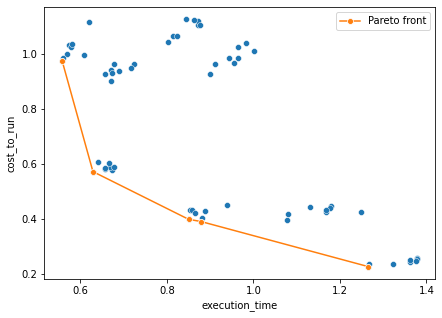

cluster_config                function_resource_map                    \
      num_workers cpu_per_worker    extractImgMetadata transformMetadata   
26            1.0            1.0                   1.0               0.1   
25            1.0            1.0                   1.0               0.1   
35            1.0            1.0                   0.1               1.0   
49            1.0            1.0                   0.1               0.1   
61            1.0            1.0                   0.1               0.1   

                                                        function_times  \
   handler thumbnail returnMetadata createThumbnail extractImgMetadata   
26     0.1       1.0            0.1             1.0           0.208039   
25     0.1       1.0            1.0             0.1           0.234356   
35     1.0       1.0            0.1             0.1           0.387284   
49     1.0       1.0            1.0             0.1           0.387059   
61     0.1       0.1            1.0             0.1           0.402757   

                                                                             \
   transformMetadata       handler thumbnail returnMetadata createThumbnail   
26          0.000016  1.430511e-06  0.252971       0.000003        0.517404   
25          0.000014  1.192093e-06  0.278294       0.000001        0.596502   
35          0.000007  4.768372e-07  0.280154       0.000003        0.802849   
49          0.000016  7.152557e-07  0.272506       0.000001        0.803559   
61          0.000018  1.192093e-06  0.703832       0.000001        1.223310   

   config_point_result                             
            loss_value execution_time cost_to_run  
26               0.558          0.558    0.973754  
25               0.629          0.629    0.572411  
35               0.850          0.850    0.399175  
49               0.879          0.879    0.390880  
61               1.265          1.265    0.227309

In [13]:
csv_file = "../Thumbnailer/optimize_GridSearch_2022_06_13-11:18:47_AM.csv"
df = read_df(csv_file)
median_df = get_median(df)
plot_pareto(median_df)
get_pareto_front(median_df)

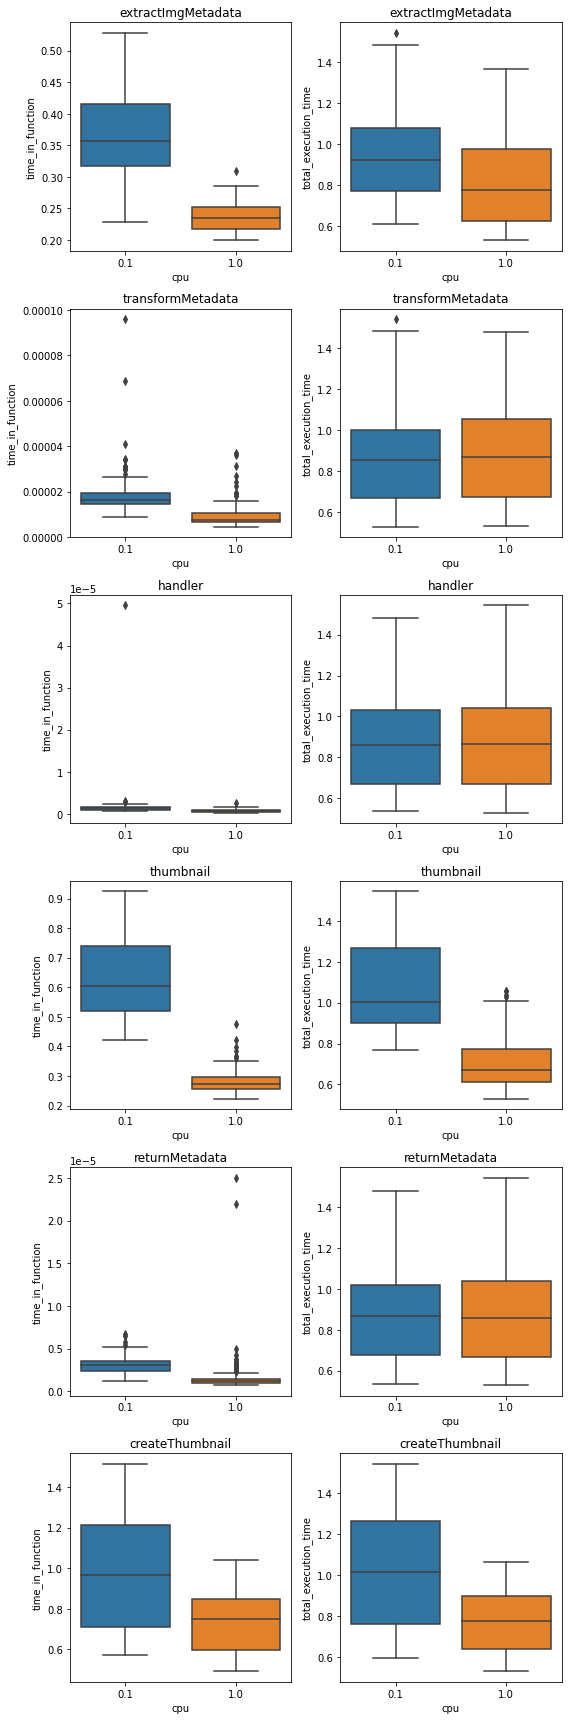

In [57]:
plot_per_function_time(df)

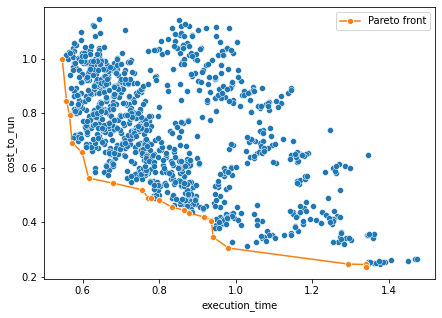

cluster_config                function_resource_map                    \
       num_workers cpu_per_worker    extractImgMetadata transformMetadata   
25             1.0            1.0                   1.0               1.0   
27             1.0            1.0                   1.0               1.0   
30             1.0            1.0                   1.0               1.0   
35             1.0            1.0                   1.0               1.0   
39             1.0            1.0                   1.0               1.0   
78             1.0            1.0                   1.0               0.7   
131            1.0            1.0                   1.0               0.4   
175            1.0            1.0                   1.0               0.4   
200            1.0            1.0                   1.0               0.1   
205            1.0            1.0                   1.0               0.1   
547            1.0            1.0                   0.4               1.0   
583            1.0            1.0                   0.4               0.7   
607            1.0            1.0                   0.4               0.7   
611            1.0            1.0                   0.4               0.7   
675            1.0            1.0                   0.4               0.4   
843            1.0            1.0                   0.1               0.7   
891            1.0            1.0                   0.1               0.7   
895            1.0            1.0                   0.1               0.7   
899            1.0            1.0                   0.1               0.4   
923            1.0            1.0                   0.1               0.4   
935            1.0            1.0                   0.1               0.4   
951            1.0            1.0                   0.1               0.4   

                                                 function_times  \
    thumbnail returnMetadata createThumbnail extractImgMetadata   
25        0.7            0.4             0.7           0.216183   
27        0.7            0.4             0.1           0.243314   
30        0.7            0.1             0.4           0.219095   
35        0.4            1.0             0.1           0.245820   
39        0.4            0.7             0.1           0.233269   
78        1.0            0.1             0.4           0.229801   
131       1.0            1.0             0.1           0.226440   
175       0.4            0.1             0.1           0.236000   
200       1.0            0.4             1.0           0.212699   
205       1.0            0.1             0.7           0.211168   
547       0.4            1.0             0.1           0.329839   
583       1.0            0.7             0.1           0.330406   
607       0.7            0.1             0.1           0.318461   
611       0.4            1.0             0.1           0.340432   
675       0.4            1.0             0.1           0.324975   
843       1.0            0.4             0.1           0.439601   
891       0.1            0.4             0.1           0.445188   
895       0.1            0.1             0.1           0.450009   
899       1.0            1.0             0.1           0.427680   
923       0.7            0.4             0.1           0.396871   
935       0.4            0.7             0.1           0.395669   
951       0.1            0.7             0.1           0.363339   

                                                                \
    transformMetadata thumbnail returnMetadata createThumbnail   
25           0.000007  0.284493   2.384186e-06        0.543365   
27           0.000010  0.336388   3.337860e-06        0.646807   
30           0.000006  0.278961   2.622604e-06        0.569507   
35           0.000007  0.414173   1.192093e-06        0.732690   
39           0.000008  0.447370   3.099442e-06        0.743781   
78           0.000015  0.251900   3.337860e-06        0.528857   
131          0.000

In [59]:
csv_file = "../Thumbnailer/optimize_GridSearch_2022_06_13-02:24:37_PM.csv"
df = read_df(csv_file)
median_df = get_median(df)
plot_pareto(median_df)
pf = get_pareto_front(median_df)
pf.sort_values('execution_time')

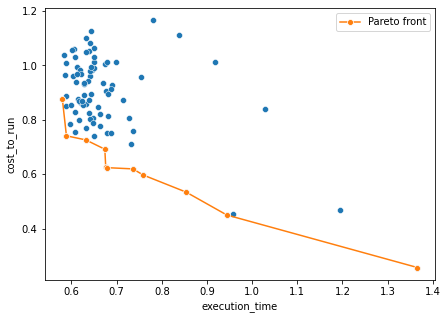

cluster_config                function_resource_map                    \
      num_workers cpu_per_worker    extractImgMetadata transformMetadata   
1             1.0            1.0                   0.1               0.1   
6             1.0            1.0                   0.4               0.6   
12            1.0            1.0                   1.0               1.0   
14            1.0            1.0                   1.0               1.0   
38            1.0            1.0                   1.0               1.0   
40            1.0            1.0                   0.9               1.0   
53            1.0            1.0                   0.8               1.0   
56            1.0            1.0                   1.0               0.1   
67            1.0            1.0                   1.0               0.1   
78            1.0            1.0                   0.1               1.0   
79            1.0            1.0                   0.8               1.0   

                                                function_times  \
   thumbnail returnMetadata createThumbnail extractImgMetadata   
1        0.1            0.1             0.1           0.427830   
6        0.6            0.4             0.2           0.336612   
12       1.0            0.1             0.1           0.261301   
14       1.0            1.0             0.4           0.235407   
38       0.8            1.0             0.3           0.267919   
40       0.8            1.0             0.8           0.261156   
53       0.9            1.0             0.5           0.273349   
56       1.0            1.0             0.1           0.249259   
67       0.7            0.1             0.1           0.260435   
78       0.7            0.2             0.2           0.448989   
79       1.0            1.0             0.1           0.303642   

                                                               \
   transformMetadata thumbnail returnMetadata createThumbnail   
1           0.000017  0.793423   2.622604e-06        1.341948   
6           0.000015  0.402846   3.337860e-06        0.829563   
12          0.000009  0.301905   3.337860e-06        0.644311   
14          0.000008  0.282884   9.536743e-07        0.561525   
38          0.000013  0.275270   1.430511e-06        0.643666   
40          0.000008  0.251113   1.430511e-06        0.552839   
53          0.000009  0.259494   1.192093e-06        0.571902   
56          0.000018  0.305120   9.536743e-07        0.653075   
67          0.000018  0.386288   3.337860e-06        0.704486   
78          0.000009  0.337606   4.053116e-06        0.904242   
79          0.000007  0.303319   9.536743e-07        0.696399   

   config_point_result                             
            loss_value execution_time cost_to_run  
1                1.366          1.366    0.256782  
6                0.854          0.854    0.534205  
12               0.676          0.676    0.627006  
14               0.589          0.589    0.741314  
38               0.674          0.674    0.692012  
40               0.580          0.580    0.876333  
53               0.632          0.632    0.726223  
56               0.679          0.679    0.624157  
67               0.759          0.759    0.597095  
78               0.944          0.944    0.450053  
79               0.736          0.736    0.619692

In [60]:
csv_file = "../Thumbnailer/optimize_BayesianOptSearch_2022_06_13-02:46:36_PM.csv"
df = read_df(csv_file)
median_df = get_median(df)
plot_pareto(median_df)
get_pareto_front(median_df)

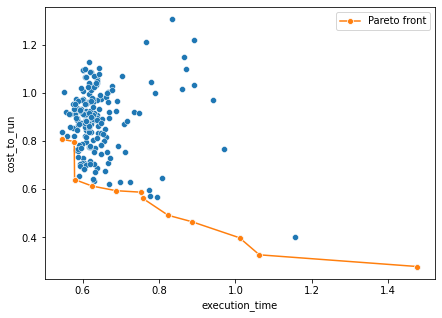

cluster_config                function_resource_map                    \
       num_workers cpu_per_worker    extractImgMetadata transformMetadata   
1              1.0            1.0                   0.1               0.1   
4              1.0            1.0                   0.2               0.1   
6              1.0            1.0                   1.0               0.1   
7              1.0            1.0                   0.6               0.2   
9              1.0            1.0                   0.1               0.1   
96             1.0            1.0                   1.0               0.5   
117            1.0            1.0                   0.2               0.9   
119            1.0            1.0                   0.9               0.9   
127            1.0            1.0                   1.0               0.4   
133            1.0            1.0                   0.5               1.0   
192            1.0            1.0                   1.0               0.9   
200            1.0            1.0                   0.7               1.0   

                                                 function_times  \
    thumbnail returnMetadata createThumbnail extractImgMetadata   
1         0.1            0.1             0.1           0.503838   
4         1.0            0.2             0.1           0.390189   
6         0.8            0.9             0.1           0.245434   
7         1.0            0.5             0.1           0.307253   
9         0.7            1.0             0.1           0.483275   
96        0.9            0.7             0.7           0.217884   
117       0.3            0.4             0.1           0.369909   
119       0.4            1.0             0.1           0.248674   
127       0.9            0.1             0.6           0.240261   
133       0.9            0.3             0.4           0.235135   
192       0.9            1.0             0.1           0.260045   
200       1.0            0.1             0.4           0.259552   

                                                                \
    transformMetadata thumbnail returnMetadata createThumbnail   
1            0.000017  0.809781       0.000004        1.450691   
4            0.000016  0.300735       0.000005        0.828425   
6            0.000018  0.349950       0.000002        0.698068   
7            0.000019  0.311109       0.000003        0.730590   
9            0.000024  0.341022       0.000001        0.984379   
96           0.000020  0.242101       0.000003        0.518259   
117          0.000011  0.510400       0.000002        0.994499   
119          0.000009  0.459505       0.000001        0.769985   
127          0.000016  0.282222       0.000003        0.548455   
133          0.000008  0.250112       0.000003        0.582823   
192          0.000014  0.294195       0.000001        0.663831   
200          0.000008  0.246171       0.000003        0.549577   

    config_point_result                             
             loss_value execution_time cost_to_run  
1                 1.477          1.477    0.279181  
4                 0.887          0.887    0.464958  
6                 0.752          0.752    0.587967  
7                 0.758          0.758    0.561858  
9                 1.011          1.011    0.398585  
96                0.547          0.547    0.806889  
117               1.063          1.063    0.327863  
119               0.824          0.824    0.491976  
127               0.578          0.578    0.798114  
133               0.625          0.625    0.613268  
192               0.688          0.688    0.594100  
200               0.579          0.579    0.640463

In [61]:
csv_file = "../Thumbnailer/optimize_BayesianOptSearch_2022_06_13-03:47:07_PM.csv"
df = read_df(csv_file)
median_df = get_median(df)
plot_pareto(median_df)
get_pareto_front(median_df)